<h1><center> Brain Tumor Detection with ResNet-18 </h1></center>
<h2><center> Bitamin Computer Vision </h2></center>
<h4><center> Team 3 </h4></center>
 <hr>
 
 <b>Description:</b>

    This notebook mainly focused on finetuning the Resnet model with Brain MRI Dataset
 

In [4]:
%%capture
!pip install imutils

In [5]:
# 라이브러리 불러오기

import os
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
from PIL import Image
import copy
from sklearn.utils import shuffle
import pandas as pd
import shutil
from IPython.display import clear_output
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

RANDOM_SEED = 42

In [6]:
data_dir="../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/"
#데이터 불러오기

In [7]:
# Data augmentation
# augment 함수 생성
# 
def data_augment(img_dir, n_samples, save_to_dir):
    img_data_generator = ImageDataGenerator(rotation_range=10, #이미지 회전 각도 범위
                                  width_shift_range=0.1, #이미지 가로 방향으로의 이동 범위
                                  height_shift_range=0.1, #이미지 세로 방향으로의 이동 범위
                                  shear_range=0.1, #이미지 전단 변환의 강도 범위
                                  brightness_range=(0.3, 1.0),#이미지 밝기 조절 범위
                                  horizontal_flip=True, #이미지를 수평으로 뒤집을지 여부를 결정합
                                  vertical_flip=True, #이미지를 수직으로 뒤집을지 여부를 결정
                                  fill_mode='nearest'#변환으로 인해 생기는 빈 픽셀을 채우는 방법을 결정
                                 )

    for filename in listdir(img_dir):
        image = cv2.imread(img_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in img_data_generator.flow(x=image,
                                             batch_size=1,
                                             save_to_dir=save_to_dir,
                                             save_prefix=save_prefix, 
                                             save_format='jpg'):
                i += 1
                if i > n_samples:
                    break

In [8]:
!mkdir augmented-images augmented-images/yes augmented-images/no

mkdir: cannot create directory ‘augmented-images’: File exists
mkdir: cannot create directory ‘augmented-images/yes’: File exists
mkdir: cannot create directory ‘augmented-images/no’: File exists


In [9]:
img_augment_path ='./augmented-images/'
# Data augmentation for the examples labeled as 'yes' representing 'true' tumor
data_augment(img_dir=data_dir+'yes',n_samples=6, save_to_dir=img_augment_path+'yes')
# Data augmentation for the examples labeled as 'No' representing 'false/no' tumor
data_augment(img_dir=data_dir+'no',n_samples=6, save_to_dir=img_augment_path+'no')

'yes' 레이블을 가진 예제 이미지들에 대한 데이터 증강: data_dir 변수에 있는 'yes' 레이블을 가진 예제 이미지들을 img_augment_path로 지정된 경로에 6개의 추가 이미지로 증강.

'no' 레이블을 가진 예제 이미지들에 대한 데이터 증강: 마찬가지로 data_dir 변수에 있는 'no' 레이블을 가진 예제 이미지들을 img_augment_path로 지정된 경로에 6개의 추가 이미지로 증강.

한 이미지를 6개의 이미지로 증강시키는 것
위의 argument 함수의 파라미터에서 각 이미지마다 랜덤으로 조합하여 6개의 이미지가 추가적으로 생성

In [10]:
data_dir = './augmented-images/'

Courtesy: Ruslan Klymentiev

In [11]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── augmented-images
    ├── no
    └── yes

12 directories


In [21]:
# Checking the dataset/images

# split the data by train/val/test
for CLASS in os.listdir(data_dir):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(data_dir + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(data_dir + CLASS)):
            img = data_dir + CLASS + '/' + FILE_NAME
            if n < 10:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [22]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### load_data
디렉토리에서 이미지를 로드하여 NumPy 배열로 변환하고, 레이블을 할당하여 데이터를 준비하는 역할을 합니다. 이 함수는 다음과 같은 기능을 수행

입력 및 출력:

dir_path: 이미지가 저장된 디렉토리 경로
img_size: 이미지의 크기를 지정하는 튜플, 기본값은 (100, 100)으로 설정

이미지 로드 및 조작:

지정된 디렉토리에서 이미지를 로드합니다.
이미지를 지정된 크기로 조정합니다.
로드된 이미지를 NumPy 배열 형식으로 변환합니다.
레이블(클래스)을 할당합니다.

데이터 준비:

이미지 데이터를 X 배열에 저장합니다.
각 이미지에 대한 클래스 레이블을 y 배열에 저장합니다.
클래스 레이블과 해당 인덱스 간의 매핑을 labels 딕셔너리에 저장합니다.

출력 및 반환:

로드된 이미지의 총 개수와 디렉토리 경로를 출력합니다.
이미지 데이터 배열 X, 클래스 레이블 배열 y, 클래스 인덱스와 레이블 간의 매핑 정보인 labels를 반환합니다.

즉, 이 함수는 이미지 데이터셋을 로드하고 준비하여 딥러닝 모델의 학습 또는 테스트에 사용할 수 있도록 처리하는 역할을 합니다.

### plot_confusion_matrix


이 함수는 주어진 혼동 행렬을 시각화하는 데 사용됩니다. 이 함수의 파라미터와 역할은 다음과 같습니다:

cm: 혼동 행렬(confusion matrix)입니다. 혼동 행렬은 분류 모델의 예측 결과와 실제 클래스 간의 관계를 나타냅니다. 이는 모델의 분류 성능을 평가하는 데 사용됩니다.

classes: 클래스의 이름을 포함하는 리스트입니다. 이는 혼동 행렬의 행과 열에 해당하는 클래스의 레이블을 제공합니다.

normalize: 혼동 행렬을 정규화할지 여부를 결정하는 매개변수입니다. 기본값은 False로 설정되어 있으며, True로 설정하면 각 클래스에 대한 정확도를 표시할 수 있습니다.

title: 그래프의 제목을 지정하는 매개변수입니다. 기본값은 'Confusion matrix'로 설정되어 있습니다.

cmap: 그래프에 사용할 색상 맵을 지정하는 매개변수입니다. 기본값은 파란색 계열의 색상 맵인 plt.cm.Blues로 설정되어 있습니다.

함수는 다음과 같은 작업을 수행합니다:

주어진 혼동 행렬을 시각화하여 그래프로 표현합니다.
정규화 매개변수에 따라 혼동 행렬을 정규화합니다.
각 셀에 해당하는 클래스 간의 관계를 표시하며, 행렬의 값은 해당 관계를 나타냅니다.
각 셀에는 색상과 함께 행렬의 값을 표시합니다.
축에는 예측된 레이블과 실제 레이블이 표시됩니다.
이를 통해 모델의 분류 성능을 시각적으로 검토하고, 클래스 간의 혼동 패턴을 확인할 수 있습니다.

In [23]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

1407 images loaded from TRAIN/ directory.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



  0%|          | 0/2 [00:00<?, ?it/s]

20 images loaded from TEST/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

354 images loaded from VAL/ directory.


### X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE): 
훈련 데이터를 로드하고 작업 공간에 저장합니다. load_data 함수를 사용하여 TRAIN_DIR에서 이미지 데이터를 로드하고, IMG_SIZE로 지정된 크기로 조정합니다. 그 결과로 X_train은 이미지 데이터를 담는 배열이 되고, y_train은 해당 이미지들의 클래스를 담는 배열이 됩니다. labels 변수는 클래스 인덱스와 클래스 레이블 간의 매핑을 담고 있는 딕셔너리입니다.

### X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE): 
테스트 데이터를 로드하고 작업 공간에 저장합니다. 위와 마찬가지로 TEST_DIR에서 이미지 데이터를 로드하고, IMG_SIZE로 지정된 크기로 조정합니다. y_test는 여기서는 사용하지 않으므로 _로 대체됩니다.

### X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE): 
검증 데이터를 로드하고 작업 공간에 저장합니다. 위와 마찬가지로 VAL_DIR에서 이미지 데이터를 로드하고, IMG_SIZE로 지정된 크기로 조정합니다. y_val는 여기서는 사용하지 않으므로 _로 대체됩니다.

이렇게 함으로써 훈련, 테스트, 검증 데이터셋이 이미지로부터 로드되고, 작업 공간에 준비됩니다.

In [24]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

y = dict(): 빈 딕셔너리 y를 생성합니다.

y[0] = [], y[1] = []: y 딕셔너리에 0과 1을 키로 갖는 빈 리스트를 추가합니다. 이 리스트는 각 클래스(레이블)에 해당하는 데이터의 개수를 저장할 것입니다.

for set_name in (y_train, y_val, y_test):: 각 데이터셋에 대해 반복합니다. 여기서 y_train, y_val, y_test는 각각 훈련, 검증, 테스트 데이터셋의 클래스(레이블)을 나타냅니다.

y[0].append(np.sum(set_name == 0)), y[1].append(np.sum(set_name == 1)): 각 데이터셋에 속한 0과 1의 개수를 계산하고, y[0]과 y[1]에 추가합니다. 이는 각 데이터셋에 속한 클래스의 수를 리스트에 저장하는 과정입니다.

trace0 = go.Bar(...), trace1 = go.Bar(...): Plotly의 막대 그래프를 생성하는 데 사용되는 데이터 트레이스를 정의합니다. 각 트레이스는 0과 1 클래스에 대한 막대를 나타냅니다. 막대 색상과 투명도도 지정됩니다.

data = [trace0, trace1]: 데이터 트레이스를 리스트에 추가합니다.

layout = go.Layout(...): 그래프의 레이아웃을 정의합니다. 제목, x축 및 y축의 레이블이 지정됩니다.

fig = go.Figure(data, layout): 데이터와 레이아웃을 사용하여 그래프 객체를 생성합니다.

iplot(fig): Plotly를 사용하여 그래프를 표시합니다.

이렇게 함으로써 각 데이터셋에 속한 클래스(레이블)의 수를 막대 그래프로 시각화하여 데이터셋의 클래스 분포를 확인할 수 있습니다.

In [25]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

### def plot_samples(X, y, labels_dict, n=50):
위의 함수는 이미지 데이터셋에서 주어진 클래스에 속하는 이미지 샘플들을 그리드 형태로 시각화하는 역할을 합니다. 각 줄에 대한 설명은 다음과 같습니다:

def plot_samples(X, y, labels_dict, n=50):: 함수의 정의부입니다. 함수는 X (이미지 데이터), y (레이블), labels_dict (클래스 레이블의 딕셔너리) 및 선택적으로 n (출력할 이미지 수, 기본값은 50)을 인수로 받습니다.

for index in range(len(labels_dict)):: 주어진 클래스 레이블 딕셔너리의 길이만큼 반복합니다. 이 반복문은 각 클래스에 대해 이미지 샘플을 그리드 형태로 시각화하는 작업을 수행합니다.

imgs = X[np.argwhere(y == index)][:n]: 주어진 클래스에 속하는 이미지 샘플을 가져옵니다. np.argwhere(y == index)를 사용하여 해당 클래스에 속하는 이미지의 인덱스를 가져온 후, 이를 사용하여 X에서 해당 이미지를 선택합니다. 이때 최대 n 개의 이미지만 선택됩니다.

j = 10, i = int(n/j): 그리드의 열의 수 j와 행의 수 i를 설정합니다. 각 이미지는 행렬의 각 셀에 하나씩 배치됩니다.

plt.figure(figsize=(15,6)): 새로운 그림(figure)을 생성하고, 이 그림의 크기를 설정합니다.

c = 1: 이미지의 순서를 추적하기 위한 카운터 변수를 초기화합니다.

for img in imgs:: 이미지들에 대한 반복문을 시작합니다.

plt.subplot(i,j,c): 그리드의 각 셀에 이미지를 배치하기 위해 서브플롯(subplot)을 생성합니다.

plt.imshow(img[0]): 현재 이미지를 시각화합니다.

plt.xticks([]), plt.yticks([]): x축 및 y축의 눈금을 제거합니다.

c += 1: 이미지 카운터를 증가시킵니다.

plt.suptitle('Tumor: {}'.format(labels_dict[index])): 그림의 제목을 설정합니다. 각 그림은 해당 클래스(종양 여부)를 나타내는 제목을 갖습니다.

plt.show(): 그림을 표시합니다.

이렇게 함으로써 함수는 각 클래스에 대한 이미지 샘플을 그리드 형태로 시각화하여 보여줍니다.

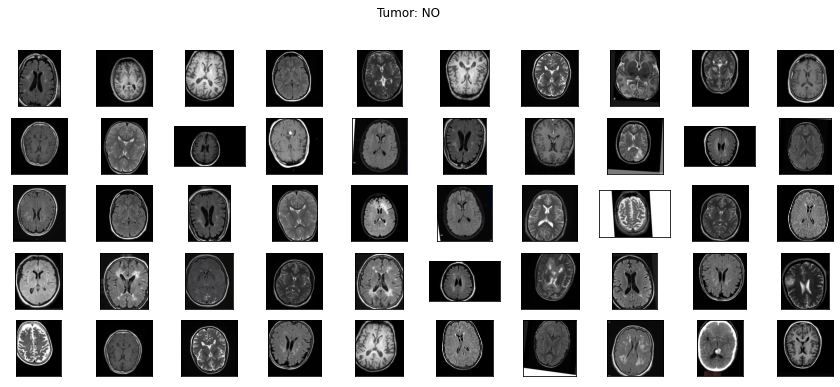

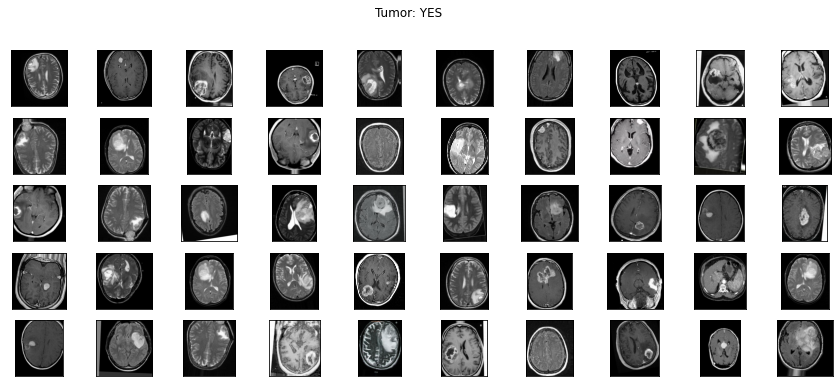

In [26]:
plot_samples(X_train, y_train, labels, 50)

In [27]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

### crop_imgs

이 함수는 이미지 세트에서 각 이미지의 뇌 종양 영역을 찾고 해당 영역을 자르는 역할을 합니다. 각 줄에 대한 설명은 다음과 같습니다:

def crop_imgs(set_name, add_pixels_value=0):: 함수의 정의부입니다. 함수는 이미지 세트(set_name)와 선택적으로 추가적인 픽셀 값(add_pixels_value, 기본값은 0)을 인수로 받습니다.

set_new = []: 새로운 이미지 세트를 저장할 빈 리스트를 생성합니다.

for img in set_name:: 주어진 이미지 세트에 대해 반복합니다.

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY): 이미지를 그레이스케일로 변환합니다.

gray = cv2.GaussianBlur(gray, (5, 5), 0): 가우시안 블러(Gaussian Blur)를 적용하여 이미지를 부드럽게 만듭니다.

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]: 이진화를 적용하여 이미지를 이진 이미지로 변환합니다.

thresh = cv2.erode(thresh, None, iterations=2), thresh = cv2.dilate(thresh, None, iterations=2): 침식과 팽창을 연달아 적용하여 이미지에서 작은 노이즈를 제거합니다.

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE): 이진화된 이미지에서 윤곽선(contour)을 찾습니다.

cnts = imutils.grab_contours(cnts): 윤곽선을 찾습니다.

c = max(cnts, key=cv2.contourArea): 가장 큰 윤곽선을 선택합니다.

extLeft, extRight, extTop, extBot: 윤곽선의 극단점을 찾습니다.

ADD_PIXELS = add_pixels_value: 추가적인 픽셀 값을 설정합니다.

new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy(): 원본 이미지를 극단점을 기준으로 잘라냅니다.

set_new.append(new_img): 새로운 이미지를 새로운 이미지 세트에 추가합니다.

return np.array(set_new): 새로운 이미지 세트를 NumPy 배열로 변환하여 반환합니다.

In [28]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y12.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y12.jpg'): 주어진 이미지 파일을 읽어옵니다.

img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC): 이미지의 크기를 IMG_SIZE로 조정합니다.

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY): 이미지를 그레이스케일로 변환합니다.

gray = cv2.GaussianBlur(gray, (5, 5), 0): 가우시안 블러(Gaussian Blur)를 적용하여 이미지를 부드럽게 만듭니다.

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]: 이진화를 적용하여 이미지를 이진 이미지로 변환합니다.

thresh = cv2.erode(thresh, None, iterations=2), thresh = cv2.dilate(thresh, None, iterations=2): 침식과 팽창을 연달아 적용하여 이미지에서 작은 노이즈를 제거합니다.

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE): 이진화된 이미지에서 윤곽선(contour)을 찾습니다.

cnts = imutils.grab_contours(cnts): 윤곽선을 찾습니다.

c = max(cnts, key=cv2.contourArea): 가장 큰 윤곽선을 선택합니다.

extLeft, extRight, extTop, extBot: 윤곽선의 극단점을 찾습니다.

img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4): 원본 이미지에 윤곽선을 그립니다.

img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1): 극단점을 이미지에 표시합니다.

new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy(): 원본 이미지를 극단점을 기준으로 잘라냅니다. 이때 추가적인 픽셀을 더해줍니다(옵션).

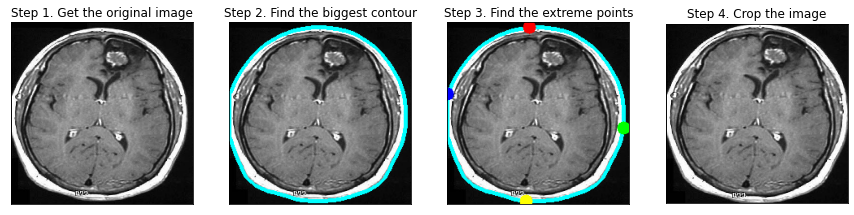

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [30]:
%%capture
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

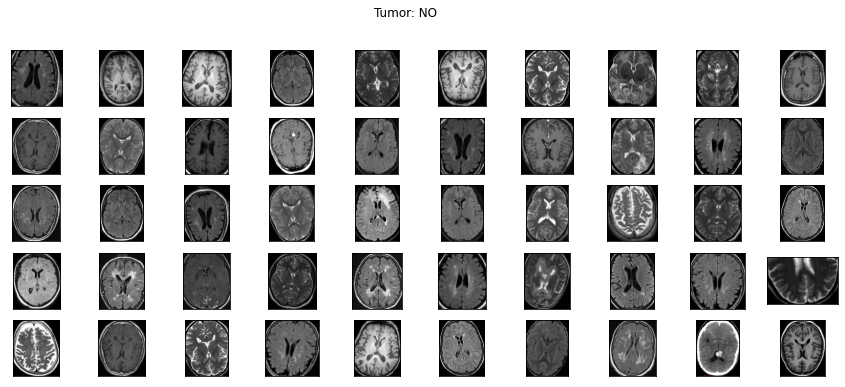

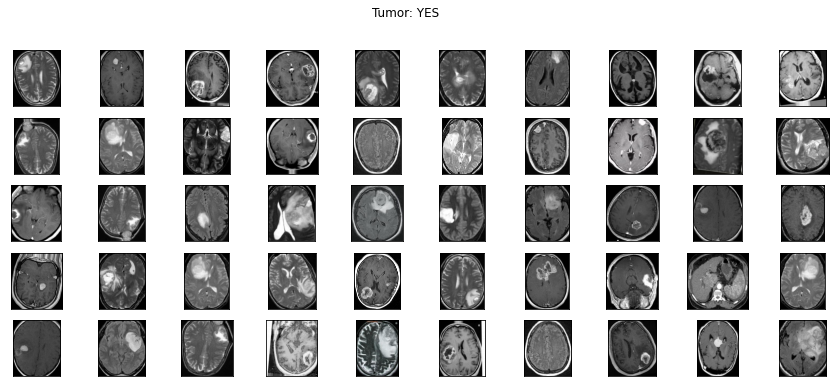

In [31]:
plot_samples(X_train_crop, y_train, labels, 50)

In [32]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [33]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [34]:
img_data_generator = ImageDataGenerator(rotation_range=10, 
                              width_shift_range=0.1, 
                              height_shift_range=0.1, 
                              shear_range=0.1, 
                              brightness_range=(0.3, 1.0),
                              horizontal_flip=True, 
                              vertical_flip=True, 
                              fill_mode='nearest'
                             )

In [35]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in img_data_generator.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 40:
        break 

위 코드는 데이터 증강을 수행하고 그 결과를 디렉토리에 저장하는 작업을 수행합니다. 각 줄에 대한 설명은 다음과 같습니다:

os.mkdir('preview'): 현재 디렉토리에 'preview'라는 이름의 새로운 디렉토리를 생성합니다. 여기에 증강된 이미지들이 저장될 것입니다.

x = X_train_crop[0]: 증강할 이미지를 선택합니다. 이 예제에서는 훈련 데이터 중 첫 번째 이미지를 선택합니다.

x = x.reshape((1,) + x.shape): 이미지를 (1, height, width, channels) 형태의 4D 배열로 재구성합니다. 이는 이미지 데이터 생성기에 전달하기 위한 사전 처리 과정입니다.

i = 0: 증강된 이미지의 수를 추적하는 변수를 초기화합니다.

for batch in img_data_generator.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):: 이미지 데이터 생성기를 사용하여 데이터를 증강하고 디렉토리에 저장합니다. flow 메서드는 입력 이미지에 대해 데이터 증강을 수행하고 배치 단위로 반환합니다. 여기서는 x를 입력으로 사용하고, batch_size를 1로 설정하여 하나의 이미지만 생성합니다. save_to_dir은 이미지를 저장할 디렉토리를 지정하고, save_prefix는 저장된 이미지 파일의 접두사를 지정합니다. save_format은 이미지 파일의 형식을 지정합니다.

i += 1: 증강된 이미지의 수를 증가시킵니다.

if i > 20: break: 증강된 이미지의 수가 20개 이상이면 루프를 종료합니다. 이는 증강된 이미지를 제한하기 위한 것입니다.

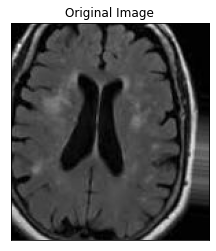

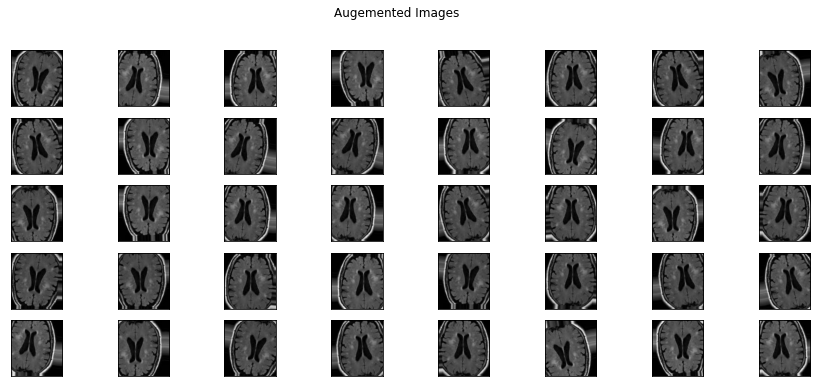

In [40]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5,8,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 5*8:
        break
plt.suptitle('Augemented Images')
plt.show()

In [41]:
img_augment_path ='../output/kaggle/working/'

In [42]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),             # resize shortest side to 100 pixels
        transforms.CenterCrop(100),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

위의 코드는 PyTorch에서 이미지 데이터에 대해 수행할 변환(transform)들을 정의하는데 사용되는 transforms.Compose()를 사용합니다. 각 변환에 대한 설명은 다음과 같습니다:

transforms.RandomRotation(10): 이미지를 무작위로 최대 ±10도 회전합니다. 이는 데이터에 다양성을 추가하기 위한 것입니다.

transforms.RandomHorizontalFlip(): 이미지를 50% 확률로 좌우 반전합니다. 이는 데이터 증강을 위한 것으로, 이미지의 좌우 대칭성을 유지하면서 다양성을 증가시킵니다.

transforms.Resize(100): 이미지의 가장 짧은 변을 100픽셀로 리사이징합니다. 이렇게 함으로써 모든 이미지가 동일한 크기로 조정됩니다.

transforms.CenterCrop(100): 이미지의 중앙 부분을 100x100 픽셀로 자릅니다. 이는 이미지의 중요한 부분을 보존하면서 이미지의 크기를 통일시키는 데 사용됩니다.

transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환합니다. 이 변환은 이미지를 [0, 1] 범위의 값으로 정규화하고, 채널을 RGB에서 CHW(채널 x 높이 x 너비)로 변경합니다.

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): 이미지의 각 채널을 정규화합니다. 이 평균 및 표준편차는 ImageNet 데이터셋을 기반으로 계산된 것으로, 일반적인 이미지 데이터에 대해 사용됩니다. 평균은 [0.485, 0.456, 0.406]이고, 표준편차는 [0.229, 0.224, 0.225]입니다.

이렇게 정의된 변환들은 훈련 데이터의 전처리 과정으로 사용되어 네트워크에 입력되기 전에 이미지를 적절하게 처리합니다.

In [43]:
train_dataset = ImageFolder('./TRAIN_CROP', transform = train_transform)
val_dataset = ImageFolder('./VAL_CROP', transform = train_transform)
test_dataset = ImageFolder('./TEST_CROP')

print('Size of training dataset :', len(train_dataset))
print('Size of validation dataset :', len(val_dataset))
print('Size of test dataset :', len(test_dataset))

class_names = val_dataset.classes

Size of training dataset : 1407
Size of validation dataset : 354
Size of test dataset : 20


In [44]:
train_dataloader=DataLoader(train_dataset,batch_size=6,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=6,shuffle=False)

위 코드는 PyTorch에서 데이터를 미니배치 단위로 로드하는 데이터 로더(DataLoader)를 생성합니다. 각 줄에 대한 설명은 다음과 같습니다:

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True): 훈련 데이터셋(train_dataset)을 로드하는 데이터 로더를 생성합니다. 이 데이터 로더는 미니배치 크기를 6으로 지정하고, 데이터를 무작위로 섞어줍니다(shuffle=True). 이것은 훈련 데이터의 순서를 무작위로 섞어 에포크마다 모델에 다양한 데이터를 제공하여 모델의 학습을 도울 수 있습니다.

val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False): 검증 데이터셋(val_dataset)을 로드하는 데이터 로더를 생성합니다. 이 데이터 로더도 미니배치 크기를 6으로 지정하고, 데이터를 섞지 않습니다(shuffle=False). 검증 과정에서는 성능을 정확하게 평가하기 위해 데이터를 섞을 필요가 없습니다.

이렇게 생성된 데이터 로더는 훈련 및 검증 단계에서 모델에 입력 데이터를 제공하고, 지정된 배치 크기에 따라 데이터를 미니배치로 분할합니다. 데이터 로더는 반복문을 통해 각 미니배치를 제공하며, 각 미니배치는 모델의 입력으로 사용됩니다.

In [45]:
dataset_sizes = len(train_dataset)

In [46]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### train_model
위의 함수는 PyTorch를 사용하여 신경망 모델을 훈련하는 데 사용됩니다. 각 줄에 대한 설명은 다음과 같습니다:

def train_model(model, criterion, optimizer, num_epochs=25):: 함수의 정의부입니다. 이 함수는 모델(model), 손실 함수(criterion), 옵티마이저(optimizer) 및 선택적으로 에폭 수(num_epochs, 기본값은 25)를 인수로 받습니다.

since = time.time(): 현재 시간을 기록합니다. 훈련 시간을 계산하기 위해 사용됩니다.

best_model_wts = copy.deepcopy(model.state_dict()): 모델의 가중치를 깊은 복사하여 최상의 모델 가중치를 저장할 변수를 초기화합니다.

best_acc = 0.0: 최상의 검증 정확도를 저장할 변수를 초기화합니다.

for epoch in range(num_epochs):: 주어진 에폭 수에 대해 반복합니다.

for phase in ['train', 'val']:: 각 에폭에 대해 훈련 및 검증 단계를 반복합니다.

model.train() 또는 model.eval(): 훈련 또는 검증 모드로 모델을 설정합니다.

data_loader = train_dataloader 또는 data_loader = val_dataloader: 훈련 또는 검증 데이터로더를 선택합니다.

for inputs, labels in data_loader:: 데이터 로더에서 미니배치를 가져옵니다.

inputs = inputs.to(device), labels = labels.to(device): 입력 데이터와 레이블을 디바이스(GPU 또는 CPU)로 이동시킵니다.

optimizer.zero_grad(): 옵티마이저의 그래디언트를 초기화합니다.

with torch.set_grad_enabled(phase == 'train'):: 훈련 단계에서만 그래디언트를 계산하기 위해 사용됩니다.

outputs = model(inputs): 모델을 통해 입력을 전달하여 출력을 얻습니다.

_, preds = torch.max(outputs, 1): 모델의 출력에서 클래스 예측을 얻습니다.

loss = criterion(outputs, labels): 모델의 출력과 실제 레이블 간의 손실을 계산합니다.

if phase == 'train': loss.backward(), optimizer.step(): 훈련 단계에서만 역전파 및 가중치 업데이트를 수행합니다.

running_loss, running_corrects: 각 미니배치의 손실과 정확한 예측 수를 누적합니다.

epoch_loss, epoch_acc: 각 에폭의 평균 손실과 정확도를 계산합니다.

if phase == 'val' and epoch_acc > best_acc:: 검증 단계에서 최상의 모델 가중치를 저장합니다.

model.load_state_dict(best_model_wts): 최상의 모델 가중치로 모델을 복원합니다.

return model: 훈련된 모델을 반환합니다.

이 함수는 훈련 및 검증 데이터에 대해 지정된 수의 에폭을 반복하면서 모델을 훈련하고, 최적의 모델을 찾습니다.

In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### visualize_model
위의 함수는 PyTorch 모델의 결과를 시각화하는 데 사용됩니다. 각 줄에 대한 설명은 다음과 같습니다:

def visualize_model(model, num_images=6):: 함수의 정의부입니다. 이 함수는 모델(model)과 시각화할 이미지 수(num_images, 기본값은 6)를 인수로 받습니다.

was_training = model.training: 현재 모델의 훈련 상태를 저장합니다.

model.eval(): 모델을 평가 모드로 설정합니다. 이는 모델의 파라미터가 평가 모드에서는 업데이트되지 않음을 의미합니다.

images_so_far = 0: 시각화된 이미지의 수를 저장하는 변수를 초기화합니다.

fig = plt.figure(): 시각화할 이미지를 담을 새로운 figure를 생성합니다.

with torch.no_grad():: 그래디언트를 계산하지 않도록 설정하여 불필요한 메모리 사용을 방지합니다.

for i, (inputs, labels) in enumerate(val_dataloader):: 검증 데이터 로더에서 미니배치를 가져옵니다.

inputs = inputs.to(device), labels = labels.to(device): 입력 데이터와 레이블을 디바이스(GPU 또는 CPU)로 이동시킵니다.

outputs = model(inputs): 모델을 통해 입력을 전달하여 출력을 얻습니다.

_, preds = torch.max(outputs, 1): 모델의 출력에서 클래스 예측을 얻습니다.

for j in range(inputs.size()[0]):: 미니배치의 각 이미지에 대해 반복합니다.

images_so_far += 1: 시각화된 이미지의 수를 증가시킵니다.

ax = plt.subplot(num_images//2, 2, images_so_far): figure에 subplot을 추가합니다.

ax.axis('off'): 이미지 축을 비활성화합니다.

ax.set_title('predicted: {}'.format(class_names[preds[j]])): 이미지 제목을 예측된 클래스로 설정합니다.

imshow(inputs.cpu().data[j]): 이미지를 시각화합니다. imshow 함수는 이미지를 화면에 표시하는 데 사용됩니다.

if images_so_far == num_images:: 시각화된 이미지의 수가 지정된 이미지 수와 같으면 함수를 종료합니다.

model.train(mode=was_training): 함수가 종료되기 전에 모델을 이전의 훈련 상태로 다시 설정합니다.

이 함수는 검증 데이터에서 모델의 예측을 시각화하여 모델의 성능을 확인하는 데 사용됩니다.

In [48]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [49]:
model_ft = models.resnet18(pretrained=True)
# model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(),  lr=1e-4, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

위의 코드는 미리 학습된 ResNet-18 모델을 불러와서 fine-tuning하는 과정을 나타냅니다. 각 줄에 대한 설명은 다음과 같습니다:

model_ft = models.resnet18(pretrained=True): 미리 학습된 ResNet-18 모델을 불러옵니다. pretrained=True는 ImageNet 데이터셋으로 미리 학습된 가중치를 사용하겠다는 것을 의미합니다.

for param in model_ft.parameters(): param.requires_grad = False: 모든 파라미터의 requires_grad 속성을 False로 설정하여 모델의 모든 층이 fine-tuning되지 않도록 합니다. 이렇게 함으로써 불러온 미리 학습된 가중치가 고정됩니다.

num_ftrs = model_ft.fc.in_features: 모델의 Fully Connected 레이어의 입력 피쳐의 수를 가져옵니다.

model_ft.fc = nn.Linear(num_ftrs, 2): 모델의 Fully Connected 레이어를 새로운 레이어로 교체합니다. 클래스의 수에 맞게 출력 크기를 조정합니다. 여기서는 이진 분류를 수행하므로 출력 크기를 2로 설정합니다.

model_ft = model_ft.to(device): 모델을 GPU 또는 CPU로 이동시킵니다. device는 이전에 설정된 장치입니다.

criterion = nn.CrossEntropyLoss(): Cross Entropy 손실 함수를 정의합니다. 이진 분류 문제이므로 사용됩니다.

optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=1e-4, weight_decay=1e-5): SGD 옵티마이저를 설정합니다. Fine-tuning할 파라미터는 모델의 마지막 Fully Connected 레이어의 파라미터만 사용됩니다. lr은 학습률을 나타내며, weight_decay는 L2 정규화의 강도를 나타냅니다.

위의 과정을 통해 불러온 ResNet-18 모델의 일부 파라미터를 고정시키고, 마지막 Fully Connected 레이어를 새로운 레이어로 교체하여 이진 분류 문제에 맞게 모델을 조정하고 있습니다.

In [50]:
# input = torch.randn((16,1,128,128))
# output = model_ft(input)
# print(output.shape)

# print(model_ft)

In [59]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4706 Acc: 0.7711
val Loss: 0.1040 Acc: 0.2033

Epoch 1/49
----------
train Loss: 0.4542 Acc: 0.7982
val Loss: 0.1045 Acc: 0.2033

Epoch 2/49
----------
train Loss: 0.4761 Acc: 0.7747
val Loss: 0.1010 Acc: 0.2047

Epoch 3/49
----------
train Loss: 0.4432 Acc: 0.7946
val Loss: 0.1009 Acc: 0.2097

Epoch 4/49
----------
train Loss: 0.4682 Acc: 0.7747
val Loss: 0.1050 Acc: 0.2040

Epoch 5/49
----------
train Loss: 0.4621 Acc: 0.7733
val Loss: 0.1041 Acc: 0.2026

Epoch 6/49
----------
train Loss: 0.4586 Acc: 0.7861
val Loss: 0.0972 Acc: 0.2132

Epoch 7/49
----------
train Loss: 0.4493 Acc: 0.7804
val Loss: 0.0948 Acc: 0.2097

Epoch 8/49
----------
train Loss: 0.4314 Acc: 0.7989
val Loss: 0.1040 Acc: 0.2068

Epoch 9/49
----------
train Loss: 0.4296 Acc: 0.8031
val Loss: 0.1026 Acc: 0.2118

Epoch 10/49
----------
train Loss: 0.4445 Acc: 0.7910
val Loss: 0.0970 Acc: 0.2111

Epoch 11/49
----------
train Loss: 0.4420 Acc: 0.7868
val Loss: 0.0979 Acc: 0.2097

Ep

In [60]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

위의 코드는 PyTorch 텐서를 이미지로 시각화하는 함수입니다. 각 줄에 대한 설명은 다음과 같습니다:

def imshow(inp, title=None):: 함수의 정의부입니다. 텐서를 이미지로 변환하여 시각화합니다.

inp = inp.numpy().transpose((1, 2, 0)): 텐서를 넘파이 배열로 변환하고, 채널을 마지막 차원으로 이동시킵니다.

mean = np.array([0.485, 0.456, 0.406]): 이미지의 평균 값입니다. ImageNet 데이터셋을 기준으로 정의된 값입니다.

std = np.array([0.229, 0.224, 0.225]): 이미지의 표준 편차 값입니다. ImageNet 데이터셋을 기준으로 정의된 값입니다.

inp = std * inp + mean: 이미지를 정규화된 값에서 원래 값으로 되돌립니다.

inp = np.clip(inp, 0, 1): 이미지의 픽셀 값을 [0, 1] 범위로 잘라냅니다.

plt.imshow(inp): 잘라진 이미지를 시각화합니다.

if title is not None: plt.title(title): 제목이 주어진 경우 제목을 설정합니다.

plt.pause(0.001): 이미지를 표시한 후 잠시 대기하여 그림이 업데이트되도록 합니다.

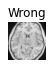

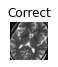

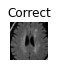

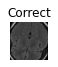

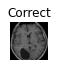

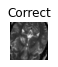

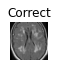

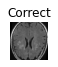

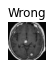

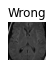

In [62]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # 예측 결과와 정답을 비교하여 출력
                if preds[j] == labels[j]:
                    ax.set_title('Correct')
                else:
                    ax.set_title('Wrong')
                    
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)
plt.ioff()
plt.show()